# Lab Course: Distributed Data Analytics Exercise Sheet 6
**Submitted by: Mohit Bansal**

**Student ID: 279314**

### FULL CODE HAS BEEN HOSTED ON GITHUB: https://github.com/MundaneMohit/Data-Analytics



### Exercise 1: Convolutional Neural Networks for Image Classification (CNN)(10 points)

1. conv1: convolution and rectified linear activation (RELU)
2. pool1: max pooling
3. FC2: fully connected layer with rectified linear activation (RELU)
4. softmax layer: final output predictions i.e. classify into one of the ten classes.


#### Build a training pipeline
1. To train the CNN model you might have to perform some standard transformation on the images to increase the size of the data. This step is called data augmentation.
2. develop a mini-batch optimization loop that picks up a small batch of images (5 to 10) and perform an iteration of optimization (see [7]).
3. Record some information for Tensorboard visualization. i.e. as scalars, graphs, distributions and histograms. You might check your Tensorboard at localhost:6006.
4. Report and plot accuracy on both training set and test set.

### Data Augmentation

For data augmentation, we do the following things:

* Cropping
* Flipping
* Adjusting brightness
* Adjusting contrast
* Normalization of the image (using mean and variance)
* One hot encoding of the output labels

These ensure that we can increase our dataset by adding dummy data while also standardizing our current data.

In [ ]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import cnn_help
import numpy as np
import pickle
from sklearn import preprocessing
import tests
import random

def normalize(x):
    return x / 255 # x - np.min(x) / (np.max(x) - np.min(x))

def one_hot_encode(x):
    z = np.zeros((len(x), 10))
    z[list(np.indices((len(x),))) + [x]] = 1
    return z

def distorted_inputs(data_dir, batch_size):
  """Construct distorted input for CIFAR training using the Reader ops.

  Args:
    data_dir: Path to the CIFAR-10 data directory.
    batch_size: Number of images per batch.

  Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
  """
  filenames = [os.path.join(data_dir, 'data_batch_%d' % i)
               for i in xrange(1, 6)]
  for f in filenames:
    if not tf.gfile.Exists(f):
      raise ValueError('Failed to find file: ' + f)

  # Create a queue that produces the filenames to read.
  filename_queue = tf.train.string_input_producer(filenames)

  with tf.name_scope('data_augmentation'):
    # Read examples from files in the filename queue.
    read_input = read_cifar10(filename_queue)
    reshaped_image = tf.cast(read_input.uint8image, tf.float32)

    height = IMAGE_SIZE
    width = IMAGE_SIZE

    # Image processing for training the network. Note the many random
    # distortions applied to the image.

    # Randomly crop a [height, width] section of the image.
    distorted_image = tf.random_crop(reshaped_image, [height, width, 3])

    # Randomly flip the image horizontally.
    distorted_image = tf.image.random_flip_left_right(distorted_image)

    # Because these operations are not commutative, consider randomizing
    # the order their operation.
    # NOTE: since per_image_standardization zeros the mean and makes
    # the stddev unit, this likely has no effect see tensorflow#1458.
    distorted_image = tf.image.random_brightness(distorted_image,
                                                 max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image,
                                               lower=0.2, upper=1.8)

    # Subtract off the mean and divide by the variance of the pixels.
    float_image = tf.image.per_image_standardization(distorted_image)

    # Set the shapes of tensors.
    float_image.set_shape([height, width, 3])
    read_input.label.set_shape([1])

    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.4
    min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN *
                             min_fraction_of_examples_in_queue)
    print ('Filling queue with %d CIFAR images before starting to train. '
           'This will take a few minutes.' % min_queue_examples)

  # Generate a batch of images and labels by building up a queue of examples.
  return _generate_image_and_label_batch(float_image, read_input.label,
                                         min_queue_examples, batch_size,
                                         shuffle=True)

### Creating the neural network

This process is broken down in the following steps:

1. Loading data
2. Data augmentation & preprocessing
3. Creation of layers for convoluted neural networks
4. Building Model
5. Training model
6. Model Optimization
7. Testing model
8. Reporting accuracy

For loading the data, we use **pickle()**. For eg.

In [ ]:
import pickle

test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))

**Step 2**: Data augmentation and preprocessing has already been mentioned before.

**Step 3**: We create 1 convolutional layer (with weights & biases and reLU activation). This layer is then **flattened** and fed into fully connected layer which is connected to final output layer.

In [ ]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    # Weight and bias
    weight = tf.Variable(tf.truncated_normal([*conv_ksize, x_tensor.shape.as_list()[3], conv_num_outputs],stddev=5e-2))
    bias = tf.Variable(tf.zeros(conv_num_outputs))

    # Apply Convolution
    conv_layer = tf.nn.conv2d(x_tensor,
                              weight,
                              strides=[1, *conv_strides, 1],
                              padding='SAME')
    # Add bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    # Apply activation function
    conv_layer = tf.nn.relu(conv_layer)

    # Apply Max Pooling
    conv_layer = tf.nn.max_pool(conv_layer,
                                ksize=[1, *pool_ksize, 1],
                                strides=[1, *pool_strides, 1],
                                padding='SAME')

    return conv_layer

def flatten(x_tensor):
    return tf.contrib.layers.flatten(x_tensor)

def fully_conn(x_tensor, num_outputs):
    return tf.layers.dense(x_tensor, num_outputs, activation=tf.nn.relu)

def output(x_tensor, num_outputs):
    return tf.layers.dense(x_tensor, num_outputs)


**Next, we create the neural network.**

In [ ]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    x = conv2d_maxpool(x, 64, (5, 5), (1, 1), (3, 3), (2, 2)) # 14x14x64
    
    # TODO: Apply a Flatten Layer
    x = flatten(x)

    # TODO: Apply 1 Fully Connected Layers
    #    Play around with different number of outputs
    x = fully_conn(x, 384)

    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    x = output(x, 10)

    # TODO: return output
    return x

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


# Preprocess and save data
cnn_help.preprocess_and_save_data('cifar-10-batches-py', normalize, one_hot_encode)
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

**We also have several helper functions (see full code for details):**


In [ ]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
def print_stats(session, feature_batch, label_batch, cost, accuracy):

**Next step is to train the model:**

(Due to memory and time limitations, training was done for 5 epochs and batch size of 5)

In [ ]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    # TODO: Implement Function
    session.run(optimizer, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: keep_probability})

epochs = 5
batch_size = 5
keep_probability = 0.75
    
print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())

    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 1
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in cnn_help.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)

    # Save Model
    saver = tf.train.Saver()
    save_model_path = './image_classification'
    save_path = saver.save(sess, save_model_path)

n_samples = 4
top_n_predictions = 3

**And finally we test the model! **

(Due to memory limitations, batch size was set to 5, and model was run for 5 epochs using only 1 batch).

In [1]:
def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')

        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0

        for test_feature_batch, test_label_batch in cnn_help.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        cnn_help.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()


NameError: name 'pickle' is not defined

Below is the model accuracy:

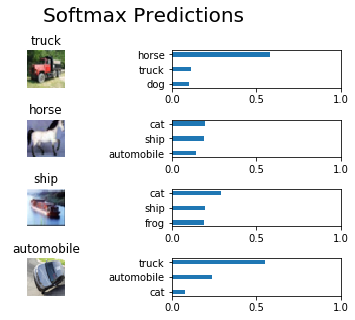


Below is the epoch-wise model accuracy:

Checking the Training on a Single Batch...

Epoch  1, CIFAR-10 Batch 1:  Loss:     2.0904 Validation Accuracy: 0.456000

Epoch  2, CIFAR-10 Batch 1:  Loss:     1.8844 Validation Accuracy: 0.494000

Epoch  3, CIFAR-10 Batch 1:  Loss:     1.2279 Validation Accuracy: 0.525000

Epoch  4, CIFAR-10 Batch 1:  Loss:     0.9804 Validation Accuracy: 0.503000

Epoch  5, CIFAR-10 Batch 1:  Loss:     0.6736 Validation Accuracy: 0.516000

#### Comments:

As we can see, the accuracy is going up at every epoch. Much better results can be obtained by using bigger epochs, batch sizes and tuning the hyperparameters.